# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

A used-car dealership wants to know what attributes influence the listing price and understand what consumers value in a used car so they fine tune their inventory 
As part of this task we will:
- Explore the data to understand distributions and missing data
- Identify a few features (e.g., vehicle age)
- Visualize categorical and numerical features
- Build and compare multiple models
- Use cross-validation and simple hyperparameter tuning
- Provide clear findings and recommendations

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The following steps will be performed to uderstand the data:

1. Inspect the data 
   - View few sample records and review schema, data types 
3. Explore data
   - Generate summary stats 
   - Visualize data  
2. Data quality assessment 
   - Check for missing data and calculate missing 
   - Check for duplicates
   - Identify outliers

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import plotly.express as px


from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor

In [3]:
#Load the data
data = pd.read_csv('data/vehicles.csv')
data.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
250708,7311885854,central NJ,26895,2014.0,ford,e450 shuttle bus,excellent,8 cylinders,gas,72284.0,clean,automatic,NaN,rwd,full-size,bus,white,nj
406236,7302023406,moses lake,0,2013.0,subaru,outback,NaN,4 cylinders,gas,179497.0,clean,automatic,4S4BRBKC0D3303216,4wd,NaN,wagon,grey,wa
11194,7316352109,phoenix,0,2017.0,honda,ridgeline,NaN,NaN,gas,70584.0,clean,automatic,5FPYK3F65HB012935,NaN,NaN,NaN,NaN,az
407221,7317053445,seattle-tacoma,7991,2008.0,ford,edge limited 4dr crossove,NaN,NaN,gas,150999.0,clean,automatic,2FMDK49C58BA93247,4wd,NaN,SUV,NaN,wa
305453,7313402731,oklahoma city,22988,2018.0,ford,edge titanium,like new,NaN,gas,59692.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ok


In [4]:
#print("Number of records:", data.shape[0])
#print("Number of columns:", data.shape[1])
#print(data.nunique())
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
# Print data stats 
print("Data stats:")
desc = data.describe(include='all')
# Transpose for redability
desc_transposed = desc.transpose().reset_index()
desc_transposed.rename(columns={'index': 'Column'}, inplace=True)
desc_transposed

Data stats:


,Column,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
1,region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173604,0.0,5900.0,13950.0,26485.75,3736928711.0
3,year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
4,manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,model,421603,29649,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,fuel,423867,5,gas,356209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,odometer,422480.0,NaN,NaN,NaN,98043.331443,213881.500798,0.0,37704.0,85548.0,133542.5,10000000.0


In [6]:
# Categorical features
categorical_features = data.select_dtypes(include=['object','category']).columns.tolist()
for col in categorical_features:
    print(f"{col}: {data[col].dropna().unique()}")

region: ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 'southeast alaska'
 'flagstaff / sedona' 'mohave county' 'phoenix' 'show low' 'sierra vista'
 'tucson' 'yuma' 'fort smith' 'jonesboro' 'little rock' 'texarkana'
 'bakersfield' 'chico' 'fresno / madera' 'gold country' 'hanford-corcoran'
 'humboldt county' 'imperial county' 'inland empire' 'los angeles'
 'mendocino county' 'merced' 'modesto' 'monterey bay' 'orange county'
 'palm springs' 'redding' 'reno / tahoe' 'sacramento' 'san diego'
 'san luis obispo' 'santa barbara' 'santa maria' 'SF bay area'
 'siskiyou county' 'stockton' 'susanville' 'ventura county'
 'visalia-tulare' 'yuba-sutter' 'boulder' 'colorado springs

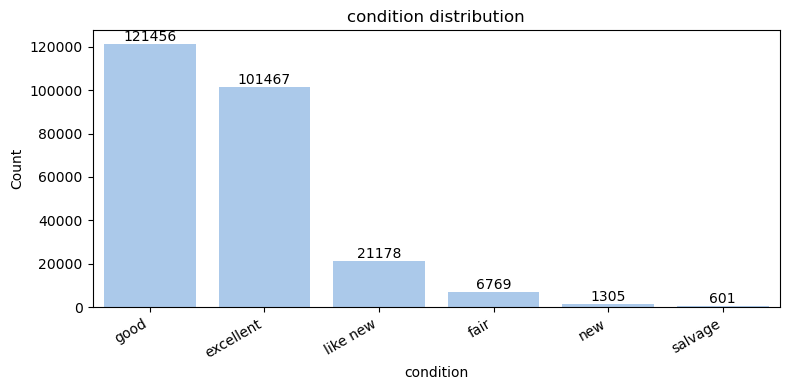

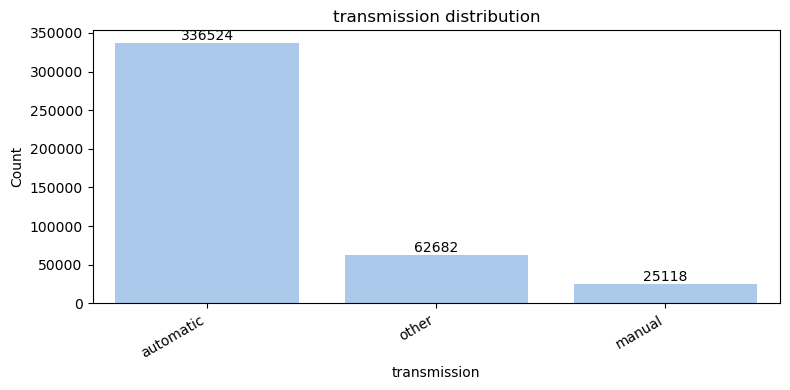

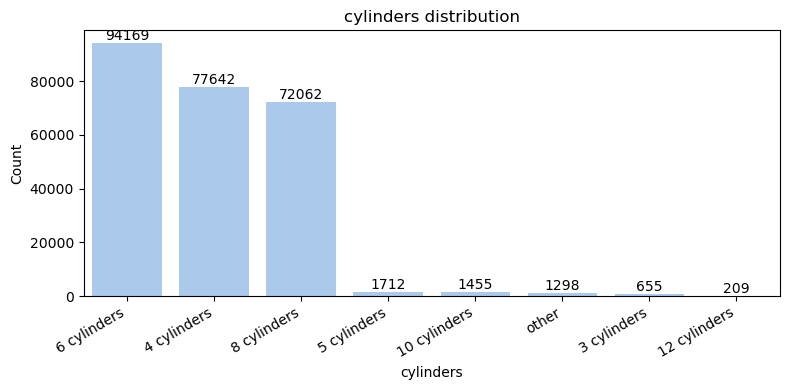

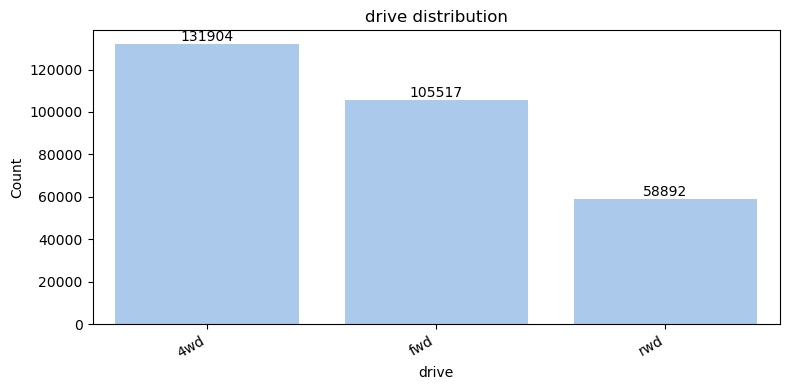

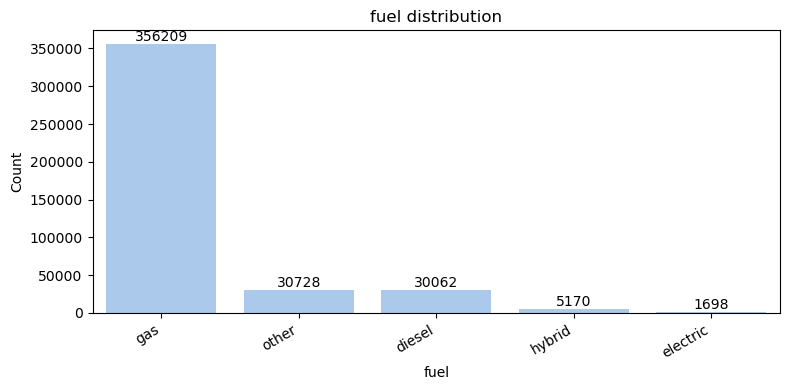

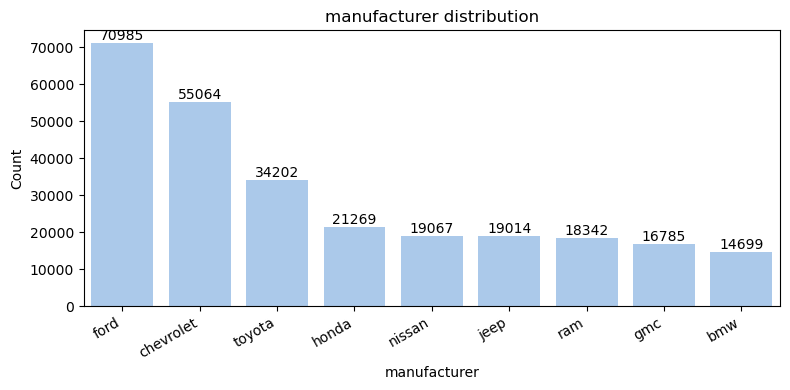

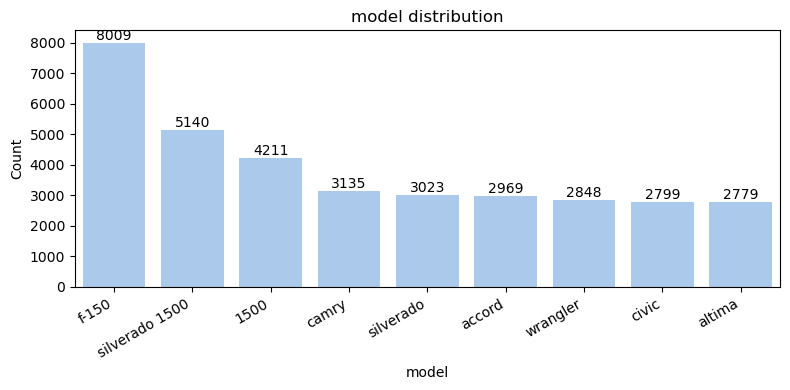

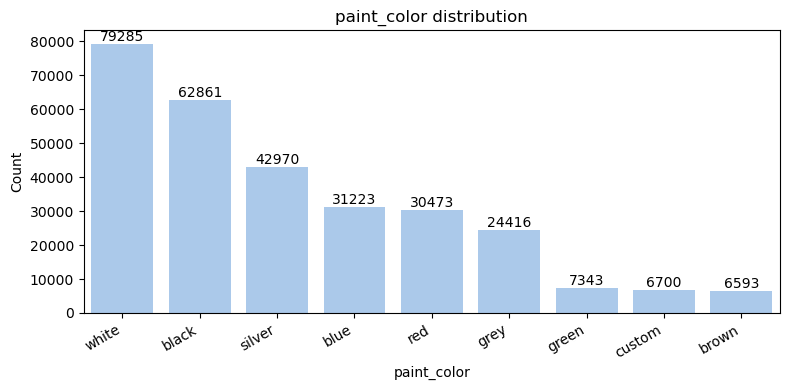

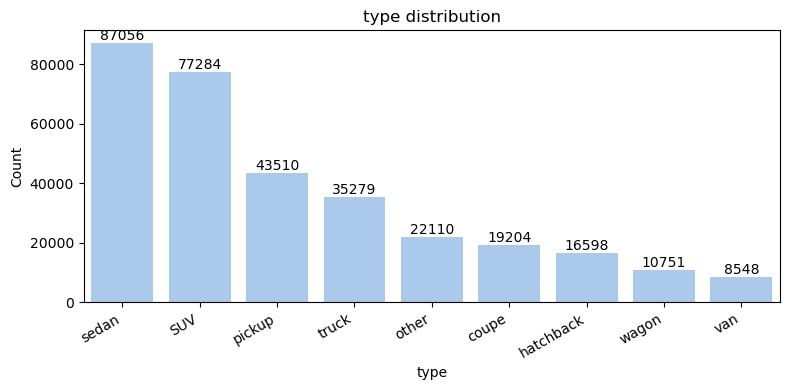

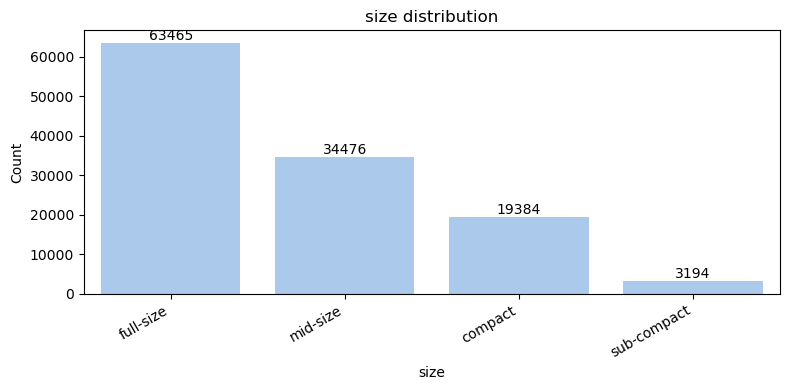

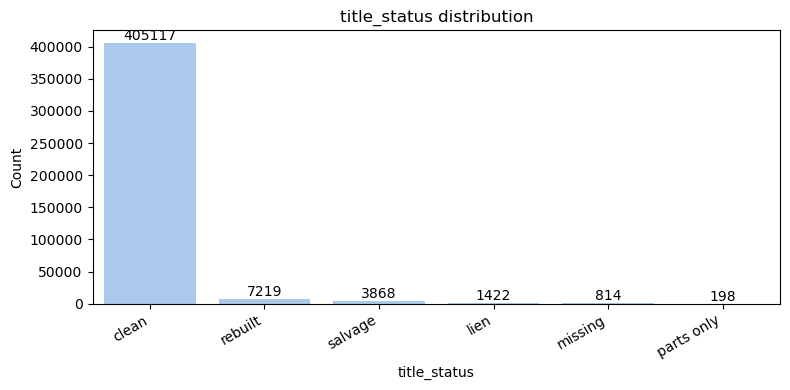

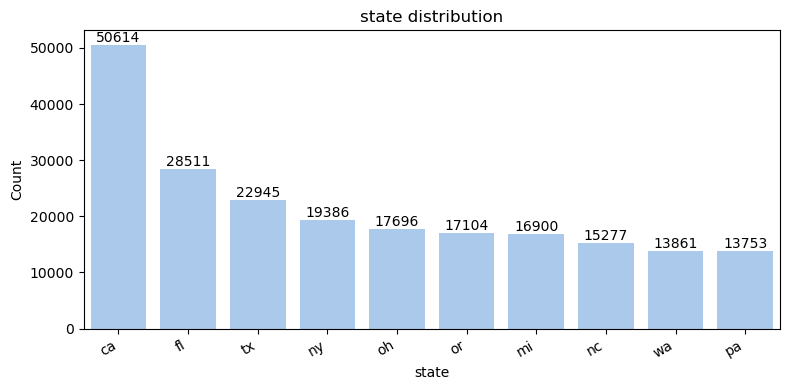

In [7]:
# Visualise distibution of records across various categorical features

def category_counts(df, col, top_n=None, order=None, plot=True, return_table=False):

    counts = df[col].value_counts(dropna=False)
    if top_n:
        counts = counts.nlargest(top_n)

    total = counts.sum()
    out = counts.reset_index()
    out.columns = [col, "Count"]
    out["%"] = (out["Count"] / total * 100).round(2)

    if plot:
        plt.figure(figsize=(8,4))
        ax = sns.barplot(data=out, x=col, y="Count", order=order, color=sns.color_palette("pastel")[0])
        ax.bar_label(ax.containers[0], fmt="%d")
        plt.title(f"{col} distribution")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

    if return_table:
       return out

cols_to_plot = [ "condition", "transmission", "cylinders", "drive", "fuel", "manufacturer", "model", "paint_color", "type", "size", "title_status", "state" ]

for col in cols_to_plot:
    #print(f"=== {col} ===")
    category_counts(data, col, top_n=10)

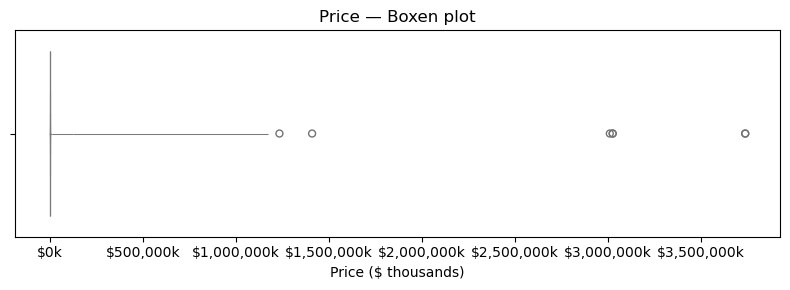

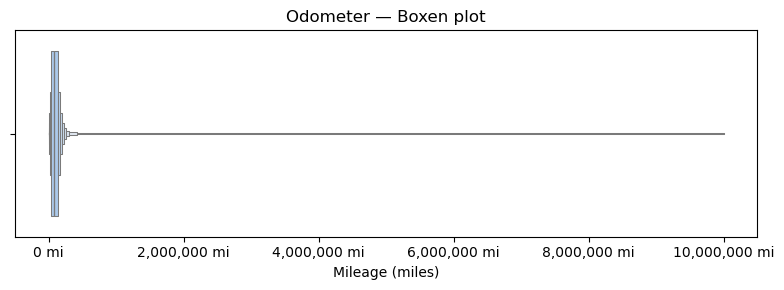

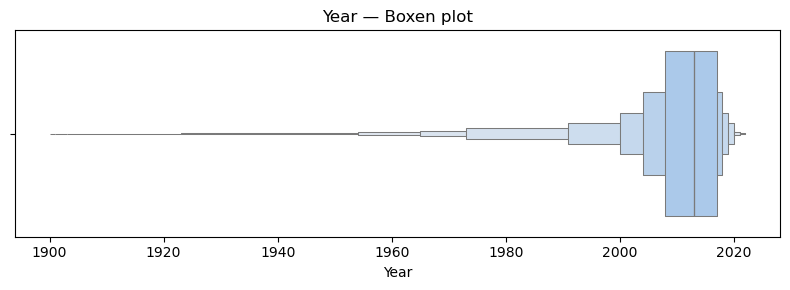

In [8]:
# numerical_features = data.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(8,3))
# Scale price before plotting
plot_data = data['price'] / 1000 
ax = sns.boxenplot(x=plot_data, color=sns.color_palette("pastel")[0])
# formatting
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}k'))
ax.set_xlabel("Price ($ thousands)")
plt.title("Price — Boxen plot")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,3))
ax = sns.boxenplot(x=data['odometer'], color=sns.color_palette("pastel")[0])
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f} mi'))
ax.set_xlabel("Mileage (miles)")
plt.title("Odometer — Boxen plot")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,3))
ax = sns.boxenplot(x=data['year'], color=sns.color_palette("pastel")[0])
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax.set_xlabel("Year")
plt.title("Year — Boxen plot")
plt.tight_layout()
plt.show()


*Observations:*
- Price: Most vehicles are under $100k, Outliers > $1M distort the scale. These unrealistic prices need to be filtered out.
- Odometer: Most cars are under 300,000 miles. Some records show extreme values up to 10 million.  These are unrealistic.
- Year: Data is mostly fine with most vehicles in the range 1995 - 2020 

In [9]:
#check for outliers
pd.set_option("display.float_format", "{:,.0f}".format)
data['price'].describe(percentiles=[.01, .05, .5, .9, .95, .99])

count         426,880
mean           75,199
std        12,182,282
min                 0
1%                  0
5%                  0
50%            13,950
90%            37,590
95%            44,500
99%            66,995
max     3,736,928,711
Name: price, dtype: float64

In [10]:
#check for outliers
pd.set_option("display.float_format", "{:,.0f}".format)
data['odometer'].describe(percentiles=[.01, .05, .5, .9, .95, .99])

count      422,480
mean        98,043
std        213,882
min              0
1%               2
5%           6,318
50%         85,548
90%        177,377
95%        204,000
99%        280,000
max     10,000,000
Name: odometer, dtype: float64

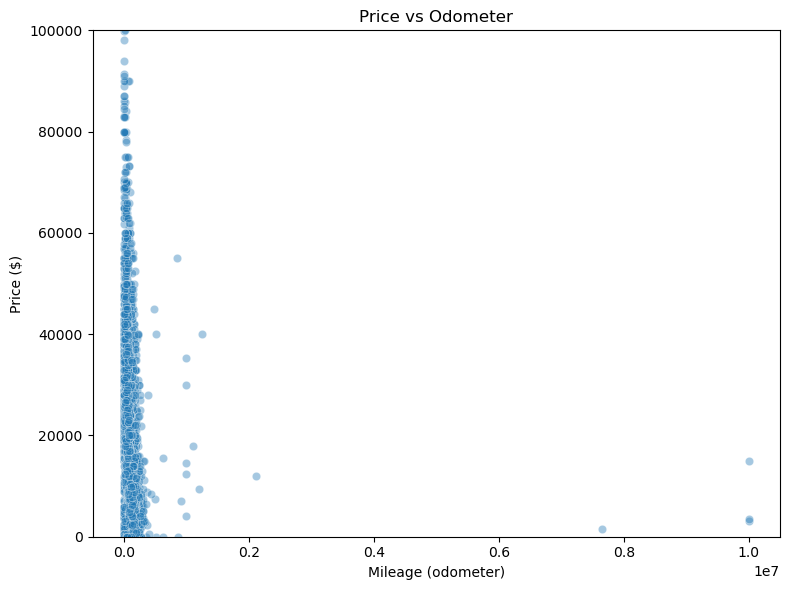

In [11]:
# check odometer and price
sample = data.sample(5000, random_state=42)

plt.figure(figsize=(8,6))
sns.scatterplot(data=sample, x="odometer", y="price", alpha=0.4)
plt.title("Price vs Odometer")
plt.xlabel("Mileage (odometer)")
plt.ylabel("Price ($)")
plt.ylim(0, 100000)
plt.tight_layout()
plt.show()

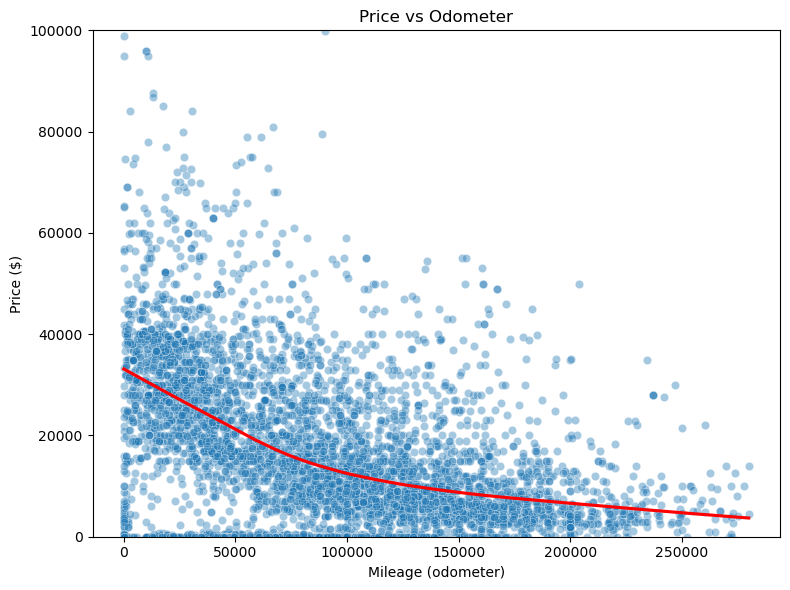

In [12]:
#filter out outlier and visualize odmeter vs price
lower, upper = data['odometer'].quantile([0.01, 0.99])
data_clean= data[(data['odometer'] >= lower) & (data['odometer'] <= upper)].copy()

sample = data_clean.sample(5000, random_state=42)

plt.figure(figsize=(8,6))
sns.scatterplot(data=sample, x="odometer", y="price", alpha=0.4)
sns.regplot(data=sample, x="odometer", y="price",scatter=False, lowess=True, color="red")

plt.title("Price vs Odometer")
plt.xlabel("Mileage (odometer)")
plt.ylabel("Price ($)")
plt.ylim(0, 100000)
plt.tight_layout()
plt.show()

*Observations:*
As expected price decrease as mileage increases. Vehicles seem to lose value quickly after ~50K miles  

### Verify Data quality 

In [13]:
#Check for missing values
missing = data.isnull().sum()[data.isnull().any()]
#% missing values per column
missing_percent = (missing/len(data)) * 100

#summary of missing values
missing_summary = pd.DataFrame({
    '#Missing': missing,
    '%Missing': missing_percent
}).sort_values(by='#Missing', ascending=False)

print("\nColumns with missing values:\n")
missing_summary


Columns with missing values:



,#Missing,%Missing
size,306361,72
cylinders,177678,42
condition,174104,41
VIN,161042,38
drive,130567,31
paint_color,130203,31
type,92858,22
manufacturer,17646,4
title_status,8242,2
model,5277,1


*Observations:*
size (72%) has very high missingness, this field needs to be dropped. Other categorical features may have some predictive value and can be imputed with "missing"

In [14]:
# Check for duplicates 
duplicates = data[data.duplicated()]
print(f"Number of duplicate records: {duplicates.shape[0]}")

Number of duplicate records: 0


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [15]:
data_clean = data.copy()

#drop identifiers - ID & VIN as these don't add any predictive signal, #drop region as it has high cardinality and drop size which has > 70% missing values 

#Columns to keep
keep = ['price','odometer','year', 'manufacturer','model', 'condition','cylinders','fuel','title_status','transmission','drive','type','paint_color','state']
data_clean  = data_clean [keep]
data_clean.describe() 

,price,odometer,year
count,"426,880","422,480","425,675"
mean,"75,199","98,043","2,011"
std,"12,182,282","213,882",9
min,0,0,"1,900"
25%,"5,900","37,704","2,008"
50%,"13,950","85,548","2,013"
75%,"26,486","133,542","2,017"
max,"3,736,928,711","10,000,000","2,022"


In [16]:
#drop rows where key values are missing
before = data_clean.shape[0]
data_clean = data_clean.dropna(subset=['price', 'year', 'odometer'])
after = data_clean.shape[0]
print(f"Dropped {before - after:,} rows missing key columns.")


# fitler out Odometer ouliers
before = data_clean.shape[0]
data_clean = data_clean[(data_clean['odometer'].fillna(0) >= 0) & (data_clean['odometer'] <= 600000)]
after = data_clean.shape[0]
print(f"Dropped {before - after:,} odometer outliers.")
data_clean.describe() 

# Filter out price outlier
before = data_clean.shape[0]
data_clean = data_clean[(data_clean['price'].fillna(0) >= 100) & (data_clean['price'] <= 200000)].copy()
after = data_clean.shape[0]
print(f"Dropped {before - after:,} price outliers.")

Dropped 5,536 rows missing key columns.
Dropped 1,253 odometer outliers.
Dropped 34,012 price outliers.


In [17]:
#covert year to age of vehicle 
data_clean["year"] = pd.to_numeric(data_clean["year"], errors="coerce")
#using max year to compute age
data_clean["age"] =  (2022 - data_clean["year"])
# clean data_clean
data_clean.loc[(data_clean["age"] < 0) | (data_clean["age"] > 60), ["year","age"]] = np.nan

data_clean = data_clean.drop(columns=['year'])

In [18]:
#Extract numeric value from clinders 
#cylinders: ['8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other', '3 cylinders' '10 cylinders' '12 cylinders']
data_clean["cylinders_num"] = ( data_clean["cylinders"].str.extract(r"(\d+)", expand=False).astype(float))

#keep for now
#data_clean = data_clean.drop(columns=['cylinders'])

In [19]:
#condition: ['good' 'excellent' 'fair' 'like new' 'new' 'salvage']
#convert to mumeric  
cond_map = { "salvage": 0, "fair": 1, "good": 2, "excellent": 3, "like new": 4, "new": 5 }
data_clean["condition_num"] = (data_clean["condition"].str.strip().str.lower().map(cond_map))

#keep for now
#data_clean = data_clean.drop(columns=['condition'])

In [20]:
#normalise categorical data
for c in ["fuel","transmission","drive","size","type","paint_color","title_status","state","manufacturer","model"]:
    if c in data_clean.columns and data_clean[c].dtype == "object":
        data_clean[c] = data_clean[c].str.lower()

In [21]:
#model cardinality is very high 
#num_models = data["model"].nunique()
print(f"No of unique models: {data['model'].nunique()}")

top_models = data_clean["model"].value_counts().nlargest(50).index
print(top_models)

# Create a new column with top models & other
data_clean["model_group"] = np.where(data_clean["model"].isin(top_models),data_clean["model"], "other")

# Drop the original model column
data_clean = data_clean.drop(columns=["model"])

No of unique models: 29649
Index(['f-150', 'silverado 1500', '1500', 'camry', 'silverado', 'accord',
       'wrangler', 'civic', 'escape', '2500', 'altima', 'tacoma', 'explorer',
       'grand cherokee', 'mustang', 'corolla', 'equinox', 'cr-v', 'focus',
       'fusion', 'corvette', 'malibu', 'rav4', 'tahoe', 'grand caravan',
       'sonata', 'impala', 'outback', 'charger', 'odyssey', 'sierra 1500',
       'silverado 2500hd', '3500', 'cruze', 'prius', 'f-250', 'elantra',
       'tundra', 'forester', 'edge', 'jetta', 'sierra', 'rogue', 'sentra',
       'wrangler unlimited', 'f150', 'sienna', 'pilot', 'camaro', 'soul'],
      dtype='object', name='model')


In [22]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386079 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          386079 non-null  int64  
 1   odometer       386079 non-null  float64
 2   manufacturer   371868 non-null  object 
 3   condition      238913 non-null  object 
 4   cylinders      229247 non-null  object 
 5   fuel           383955 non-null  object 
 6   title_status   378861 non-null  object 
 7   transmission   384564 non-null  object 
 8   drive          268420 non-null  object 
 9   type           302961 non-null  object 
 10  paint_color    271981 non-null  object 
 11  state          386079 non-null  object 
 12  age            383714 non-null  float64
 13  cylinders_num  228221 non-null  float64
 14  condition_num  238913 non-null  float64
 15  model_group    386079 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 50.1+ MB


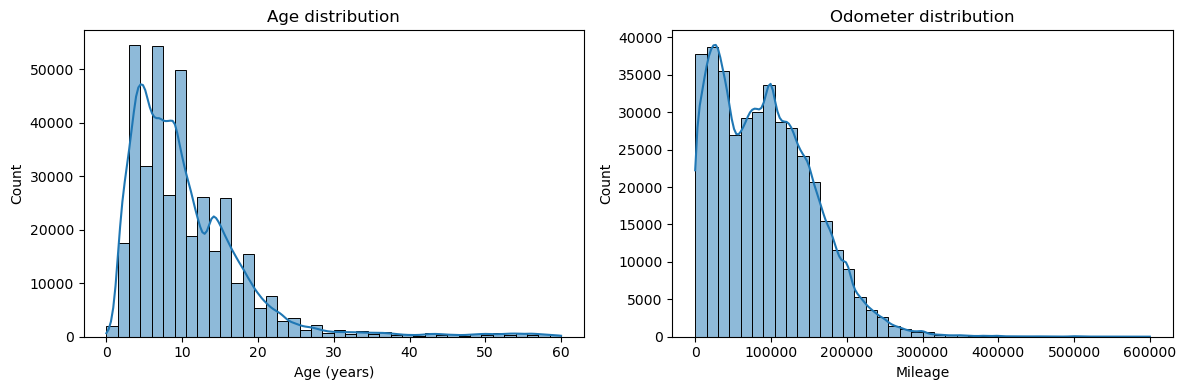

In [23]:
#plot age & odometer distribution on clean data
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data_clean['age'], kde=True, bins=40, ax=axes[0])
axes[0].set_title("Age distribution")
axes[0].set_xlabel("Age (years)")
sns.histplot(data_clean['odometer'], kde=True, bins=40, ax=axes[1])
axes[1].set_title("Odometer distribution")
axes[1].set_xlabel("Mileage")
plt.tight_layout()

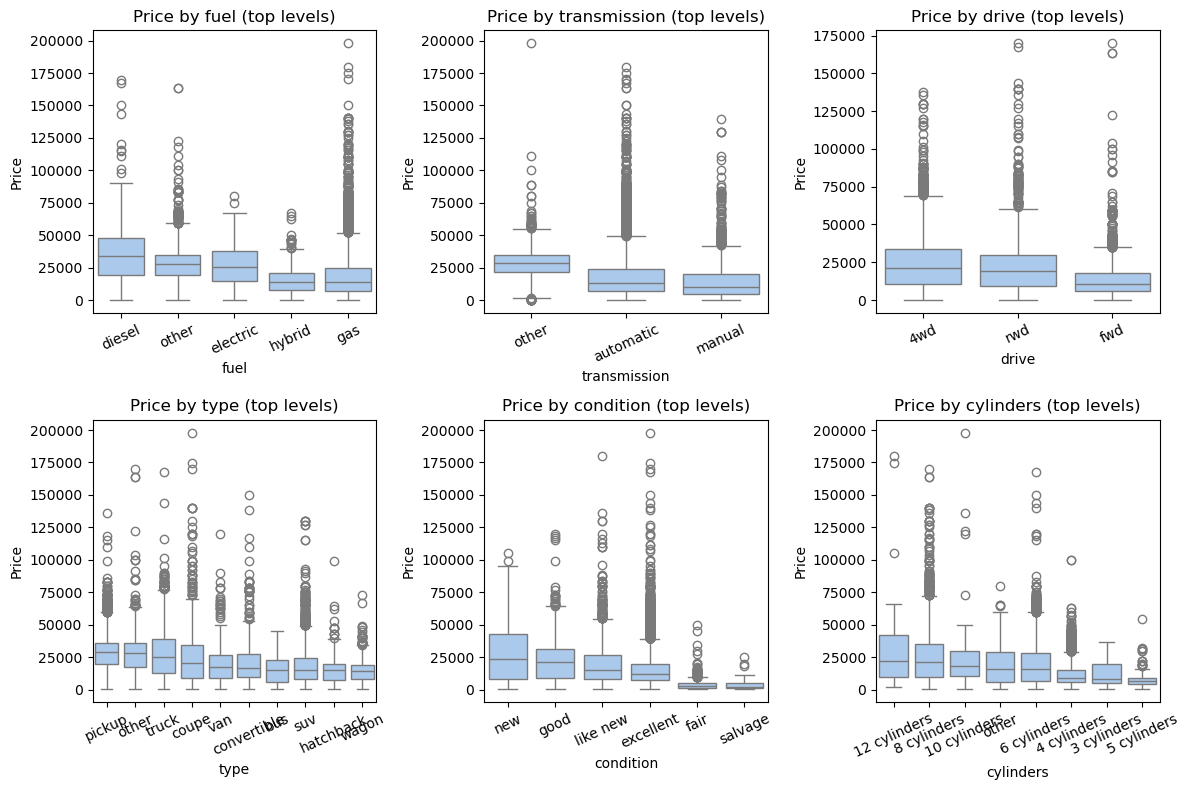

In [24]:
#plot price vs key categorical feature on clean data
cols = ['fuel','transmission','drive','type', 'condition', 'cylinders' ]
sample = data_clean.sample(min(40000, len(data_clean)), random_state=42)
fig, axes = plt.subplots(2,3, figsize=(12,8))

for ax, col in zip(axes.ravel(), cols):
    order = sample.groupby(col)['price'].median().sort_values(ascending=False).index[:10]
    sns.boxplot(data=sample[sample[col].isin(order)], x=col, y='price', order=order, ax=ax, color=sns.color_palette("pastel")[0])
    ax.set_title(f"Price by {col} (top levels)")
    ax.set_xlabel(col)
    ax.set_ylabel("Price")
    ax.tick_params(axis='x', rotation=25)
plt.tight_layout()


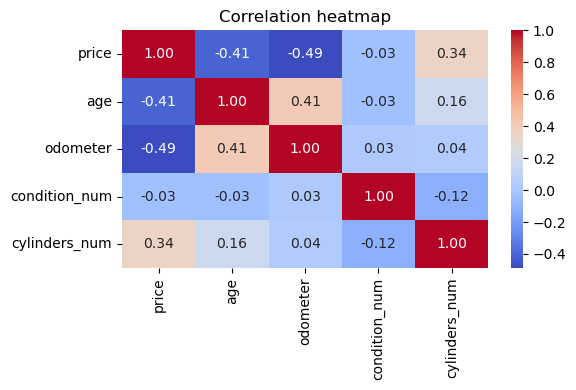

In [25]:
# plot the correlation
plt.figure(figsize=(6,4))
sns.heatmap(data_clean[['price','age','odometer','condition_num','cylinders_num']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.tight_layout()

In [26]:
def price_by_category(df, col, min_count=50):
    out = (
        df.groupby(col)["price"]
          .agg(count="count", median="median", mean="mean", min="min", max="max", std="std")
          .query("count >= @min_count")
          .sort_values("median", ascending=False)
          .round(0)
          .head(10)
    )
    return out

cols = ["fuel","condition", "cylinders", "transmission","drive","type","paint_color","title_status","state","manufacturer"]

for c in cols:
    t = price_by_category(data_clean, c,)
    styled = (
            t.round(0)
             .style.format({"count":"{:,}", "median":"${:,.0f}", "mean":"${:,.0f}", "min":"${:,.0f}", "max":"${:,.0f}", "std":"${:,.0f}"})
             .set_caption(f"Prices by {c} top 10")
        )
    display(styled)


,count,median,mean,min,max,std
fuel,,,,,,
diesel,"25,657","$31,998","$33,820",$100,"$200,000","$20,345"
other,"27,788","$27,890","$28,095",$100,"$163,540","$14,114"
electric,"1,611","$24,995","$25,913",$100,"$130,000","$16,680"
gas,"324,058","$13,750","$17,036",$100,"$199,999","$13,581"
hybrid,"4,841","$12,990","$15,519",$100,"$109,999","$11,206"


,count,median,mean,min,max,std
condition,,,,,,
new,"1,072","$21,500","$28,792",$103,"$182,000","$27,072"
good,"118,363","$20,990","$21,039",$100,"$200,000","$13,209"
like new,"19,841","$14,950","$19,350",$100,"$195,000","$16,435"
excellent,"92,522","$11,995","$15,551",$100,"$200,000","$12,978"
fair,"6,555","$2,800","$4,008",$100,"$123,456","$5,023"
salvage,560,"$1,997","$3,803",$200,"$35,989","$4,793"


,count,median,mean,min,max,std
cylinders,,,,,,
12 cylinders,181,"$28,000","$41,015",$203,"$179,888","$41,102"
8 cylinders,"65,509","$20,995","$23,968",$100,"$199,999","$17,581"
10 cylinders,"1,147","$20,900","$24,937",$153,"$197,999","$24,621"
6 cylinders,"87,221","$15,000","$18,458",$100,"$167,500","$14,086"
other,"1,026","$14,000","$21,058",$109,"$130,000","$19,743"
3 cylinders,590,"$10,122","$13,499",$191,"$128,995","$12,267"
4 cylinders,"71,922","$8,995","$11,104",$100,"$195,000","$8,180"
5 cylinders,"1,651","$6,499","$7,844",$112,"$144,832","$6,924"


,count,median,mean,min,max,std
transmission,,,,,,
other,"60,844","$28,590","$28,295",$100,"$199,999","$9,925"
automatic,"300,678","$12,995","$17,391",$100,"$200,000","$15,078"
manual,"23,042","$9,999","$14,963",$100,"$200,000","$15,403"


,count,median,mean,min,max,std
drive,,,,,,
4wd,"118,174","$20,400","$23,572",$100,"$195,000","$16,716"
rwd,"54,084","$18,995","$21,056",$100,"$185,886","$15,112"
fwd,"96,162","$10,388","$12,653",$100,"$169,950","$9,531"


,count,median,mean,min,max,std
type,,,,,,
pickup,"40,597","$27,995","$28,517",$123,"$135,900","$14,457"
other,"19,745","$27,990","$27,579",$100,"$169,950","$15,307"
truck,"30,215","$25,000","$27,276",$100,"$200,000","$18,167"
coupe,"17,807","$19,999","$23,011",$109,"$197,999","$18,316"
van,"7,805","$16,406","$18,550",$100,"$160,000","$13,172"
convertible,"7,294","$15,995","$20,584",$142,"$159,991","$18,206"
suv,"69,467","$14,900","$17,554",$100,"$195,000","$13,018"
hatchback,"15,787","$14,590","$15,095",$100,"$98,995","$9,462"
wagon,"9,849","$12,995","$14,441",$109,"$199,999","$9,863"


,count,median,mean,min,max,std
paint_color,,,,,,
white,"71,374","$19,995","$22,621",$100,"$195,000","$15,155"
black,"57,684","$18,990","$21,888",$100,"$169,999","$15,283"
orange,"1,829","$18,590","$19,536",$100,"$152,995","$14,255"
red,"28,407","$16,500","$19,396",$100,"$179,995","$14,189"
yellow,"1,998","$15,000","$19,402",$159,"$199,999","$18,323"
blue,"28,969","$13,985","$17,253",$111,"$169,888","$13,705"
silver,"39,443","$13,500","$16,874",$100,"$184,950","$12,870"
custom,"6,229","$12,987","$16,489",$122,"$150,000","$13,398"
brown,"6,139","$12,000","$16,166",$163,"$118,500","$12,963"


,count,median,mean,min,max,std
title_status,,,,,,
lien,"1,404","$17,999","$22,216",$400,"$195,000","$16,854"
clean,"365,827","$15,990","$19,290",$100,"$200,000","$15,040"
rebuilt,"6,977","$10,442","$12,793",$108,"$179,995","$9,716"
salvage,"3,780","$7,495","$9,708",$123,"$123,456","$9,021"
missing,710,"$2,900","$5,259",$109,"$49,000","$7,245"
parts only,163,"$1,500","$3,477",$100,"$50,000","$5,851"


,count,median,mean,min,max,std
state,,,,,,
wv,998,"$25,990","$25,476",$450,"$163,540","$15,445"
ak,"3,400","$22,850","$24,086",$100,"$145,000","$14,168"
mt,"5,940","$22,000","$24,477",$122,"$163,540","$16,675"
ut,"1,118","$20,000","$25,754",$500,"$160,000","$21,445"
al,"4,618","$19,990","$21,004",$199,"$140,000","$13,598"
mo,"3,892","$19,983","$22,852",$175,"$139,950","$15,292"
wy,573,"$19,977","$22,467",$500,"$125,000","$15,290"
wa,"12,240","$19,954","$24,704",$102,"$185,886","$20,052"
hi,"2,677","$18,995","$21,219",$100,"$118,000","$15,973"


,count,median,mean,min,max,std
manufacturer,,,,,,
ferrari,65,"$98,900","$99,459","$2,034","$185,886","$39,178"
tesla,841,"$37,990","$39,585",$348,"$104,990","$14,095"
porsche,"1,272","$29,997","$33,018",$159,"$179,999","$24,136"
ram,"16,261","$29,995","$30,101",$101,"$148,000","$16,112"
alfa-romeo,853,"$29,590","$29,449","$1,000","$62,950","$5,153"
jaguar,"1,886","$28,990","$27,392",$134,"$150,000","$15,099"
rover,"1,953","$25,590","$29,139",$101,"$129,888","$20,254"
audi,"7,079","$24,990","$25,123",$129,"$160,000","$15,495"
gmc,"15,226","$24,000","$25,169",$123,"$175,000","$17,172"


In [27]:
#keeping condition as categorical and cylinders as numerical
data_clean = data_clean.drop(columns=['condition_num', 'cylinders'])

for c in ['price','odometer','age','cylinders_num']:
    if c in data_clean: data_clean[c] = data_clean[c].astype('float32')

*Observations:*
 From the correlation map, the strongest numeric predictors of price are odometer, age, and no of cylinders. interestingly the condition of vehicle appears to be less reliable as a numeric predictor, this could be inconsisency in data or a non-linear realtionship. So condition will be treated as categorical.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [28]:
# tune on smaller dataset
# data_small = data_clean.sample(n=50_000, random_state=42) 

df = data_clean

y = df['price'].values
X = df.drop(columns=['price'])

numeric_features = ['age','odometer', 'cylinders_num']
categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()

#numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
#numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), 
    ("qtf", QuantileTransformer(output_distribution="normal", random_state=42))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist",  min_frequency=200, sparse_output=False))
])

preprocess = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

# Bin prices into categories for stratification, 10 bins by quantiles
price_bins = pd.qcut(df["price"], q=10, duplicates="drop")  
# Split with shuffle + stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=price_bins)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

preprocess

Train size: (308863, 13)  Test size: (77216, 13)


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('qtf',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42))]),
                                 ['age', 'odometer', 'cylinders_num']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False))]),
                                 ['manufacturer', 'condition', 'fuel',
                                  'title_status', 'transmission', 'drive',
                                  'type', 'paint_color', 'state',
                                  'model_group'])])

In [29]:
# Get the baseline
baseline_pred = np.full_like(y_test, fill_value=np.median(y_train), dtype=float)

mae_base  = mean_absolute_error(y_test, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, baseline_pred))
r2_base   = float(r2_score(y_test, baseline_pred))
print(f"Baseline (Median): MAE={mae_base:.0f}, RMSE={rmse_base:.0f}, R2={r2_base:.3f}")

# append to results
results = []
results.append(("Baseline (Median)",  mae_base, rmse_base, r2_base))

Baseline (Median): MAE=11330, RMSE=15455, R2=-0.054


In [30]:
#Fit the model, predict, and return MAE, RMSE, R2
def evaluate_model(model, X_train, y_train, X_test, y_test):    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2   = float(r2_score(y_test, preds))
    return mae, rmse, r2


In [31]:
#setup models
models = {
    "Linear Regression": Pipeline([("prep", preprocess), ("model", LinearRegression())  ]),
    "Ridge Regression": Pipeline([("prep", preprocess), ("model", Ridge(alpha=5.0)) ]),
    "Lasso Regression": Pipeline([("prep", preprocess), ("model", Lasso(alpha=0.5, max_iter=10000))]),
    #"Random Forest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1))]),
    "Random Forest": Pipeline([("prep", preprocess),("model", RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=2, max_features="sqrt", max_samples=0.8, n_jobs=-1, random_state=42))]),
    "Gradient Boosting": Pipeline([("prep", preprocess),("model", GradientBoostingRegressor(random_state=42))])
    #"Hist Gradient Boosting": Pipeline([("prep", preprocess), ("model", HistGradientBoostingRegressor(learning_rate=0.06, max_depth=8, max_iter=300, early_stopping=True, validation_fraction=0.1, random_state=42 ))])
}


In [32]:
# Evaluate all models
for name, model in models.items():
    mae, rmse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append((name, float(mae), float(rmse), float(r2)))

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
results_df["MAE"]  = results_df["MAE"].map("{:,.0f}".format)
results_df["RMSE"] = results_df["RMSE"].map("{:,.0f}".format)
results_df["R2"]   = results_df["R2"].map("{:.3f}".format)
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df

,Model,MAE,RMSE,R2
0,Baseline (Median),"11,330","15,455",-0.054
1,Random Forest,"4,725","7,775",0.733
2,Gradient Boosting,"5,226","8,649",0.670
3,Linear Regression,"5,908","9,465",0.605
4,Ridge Regression,"5,908","9,465",0.605
5,Lasso Regression,"5,906","9,466",0.605


*Observations:*

Testing several models to predict used car prices and comparing against a simple baseline using MAE (Mean Absolute Error - the average difference between predicted and actual price), RMSE (Root Mean Squared Error) and R2 (proportion of variance in prices explained)

- Baseline (Median) performed poorly, with errors of $11k+
- Random Forest is the best model with lowest error to $4,725 (MAE) and explains ~73% of variation in car prices (R2 = 0.733) and RMSE shows typical errors are under $8,000
- Gradient Boosting, Linear, Ridge, and Lasso regression all perform reasonably well, but lag behind Random Forest

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [33]:
#cross validate models to check consistency
def evaluate_models_cv(models, X, y, n_splits=5, random_state=42):
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scoring = { "MAE":  "neg_mean_absolute_error", "RMSE": "neg_root_mean_squared_error", "R2": "r2" }
    rows = []
    for name, est in models.items():
        cvres = cross_validate(est, X, y, cv=cv, scoring=scoring)
        mae  = -cvres["test_MAE"]
        rmse = -cvres["test_RMSE"]
        r2   = cvres["test_R2"]
        rows.append({
            "Model": name,
            "MAE":  f"{mae.mean():,.0f} ± {mae.std():,.0f}",
            "RMSE": f"{rmse.mean():,.0f} ± {rmse.std():,.0f}",
            "R2":   f"{r2.mean():.3f} ± {r2.std():.3f}"
        })

    return pd.DataFrame(rows)

In [34]:
results = evaluate_models_cv(models, X, y, n_splits=5)

In [35]:
results

,Model,MAE,RMSE,R2
0,Linear Regression,"5,876 ± 18","9,350 ± 46",0.610 ± 0.002
1,Ridge Regression,"5,876 ± 18","9,350 ± 46",0.610 ± 0.002
2,Lasso Regression,"5,874 ± 18","9,350 ± 46",0.610 ± 0.002
3,Random Forest,"4,677 ± 7","7,667 ± 37",0.738 ± 0.001
4,Gradient Boosting,"5,188 ± 16","8,537 ± 48",0.675 ± 0.002


*Observation:* 
All models are consistent but Random Forest is more accurate and reliable

In [36]:
# Perform hyperparameter tuning using GridSearchCV. 
# Test Random Forest settings with 3-fold cross-validation.
# Using -ve MAE as the scoring metric as it is easier to interpret.

rf_pipe = models["Random Forest"] 
param_grid = { "model__n_estimators": [100, 200], "model__max_depth": [10, 20, None], "model__min_samples_split": [2, 5] }

grid = GridSearchCV( rf_pipe, param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV MAE: 3646.7463457233357


In [37]:
#Final test set matrix
best_rf = grid.best_estimator_
preds = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2   = r2_score(y_test, preds)

print(f"Tuned RF — MAE: {mae:,.0f}, RMSE: {rmse:,.0f}, R²: {r2:.3f}")

Tuned RF — MAE: 3,441, RMSE: 6,395, R²: 0.820


*Observations:*
- With the tuned model, MAE = $3,441. On average, predictions are only off by about $3.4k per vehicle. 
- RMSE = $6,395; Indicates that Larger errors are under $6.4k on average and the model avoids extreme mispricings.
- R2 = 0.820; The model exhibits a strong level of accuracy for real-world pricing explains over 82% of the variation in car prices

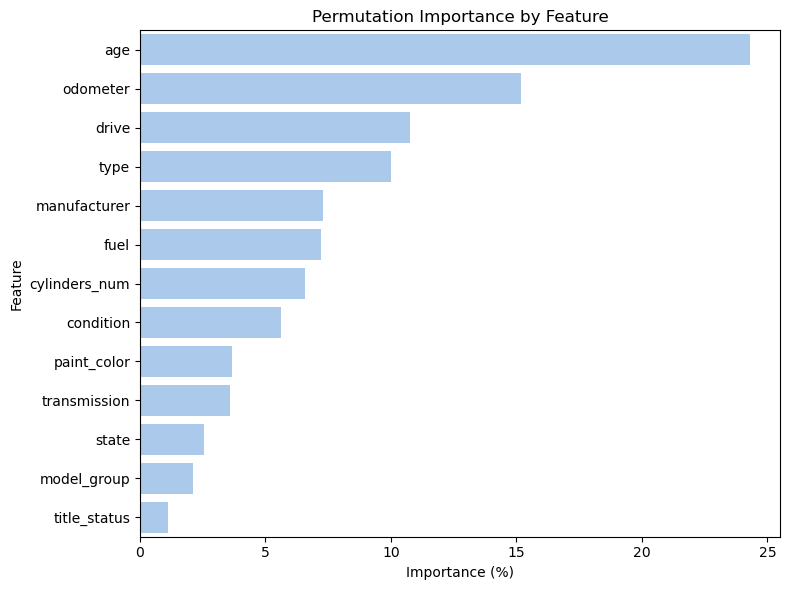

,feature,importance,importance_std,importance_pct
10,age,"3,972",22,24
0,odometer,"2,481",38,15
6,drive,"1,762",20,11
7,type,"1,639",18,10
1,manufacturer,"1,192",14,7
3,fuel,"1,178",32,7
11,cylinders_num,"1,074",17,7
2,condition,917,18,6
8,paint_color,599,9,4
5,transmission,588,16,4


In [46]:
from sklearn.inspection import permutation_importance

best = grid.best_estimator_

# subsample by position to avoid index issues
n = len(X_test)
pos = np.random.RandomState(42).choice(n, size=min(5000, n), replace=False)
X_perm = X_test.iloc[pos]
y_perm = y_test[pos] if isinstance(y_test, np.ndarray) else y_test.iloc[pos]

perm = permutation_importance(best, X_perm, y_perm, n_repeats=5, random_state=42, scoring="neg_mean_absolute_error")

# feature names are the raw columns (same order as X)
feature_names = list(X_perm.columns)

imp = (pd.DataFrame({"feature": feature_names, "importance": perm.importances_mean, "importance_std": perm.importances_std}).sort_values("importance", ascending=False))

# Normalize to percent
imp["importance_pct"] = 100 * imp["importance"] / imp["importance"].sum()
# Sort for top 20
imp = imp.sort_values("importance_pct", ascending=False)

# --- Plot ---
plt.figure(figsize=(8,6))
sns.barplot(data=imp, y="feature", x="importance_pct", orient="h", color=sns.color_palette("pastel")[0])
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Importance by Feature")
plt.tight_layout()

#plt.savefig('images/feature_importance.png')

plt.show()

imp

imp.head(20)

In [39]:
#rerun feature importance for granular output
best = grid.best_estimator_
pre  = best.named_steps["prep"]
mdl  = best.named_steps["model"]

# subsample
n = len(X_test)
pos = np.random.RandomState(42).choice(n, size=min(5000, n), replace=False)
X_perm_raw = X_test.iloc[pos]
y_perm = y_test[pos] if isinstance(y_test, np.ndarray) else y_test.iloc[pos]

# transform X and get expanded feature names
X_perm = pre.transform(X_perm_raw)
feature_names = pre.get_feature_names_out()

# permutation importance on the model
perm = permutation_importance( mdl, X_perm, y_perm, n_repeats=5, random_state=42, scoring="neg_mean_absolute_error")

imp = (pd.DataFrame({"feature": feature_names, "importance": perm.importances_mean, "importance_std": perm.importances_std}).sort_values("importance", ascending=False))
imp.head(20)

,feature,importance,importance_std
0,numeric__age,"3,972",22
1,numeric__odometer,"2,481",38
2,numeric__cylinders_num,"1,074",17
64,categorical__drive_4wd,735,18
65,categorical__drive_fwd,548,23
50,categorical__fuel_gas,521,18
48,categorical__fuel_diesel,475,13
43,categorical__condition_good,365,9
76,categorical__type_pickup,335,11
63,categorical__transmission_other,310,8


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

The goal was to identify the most important factors that influenced used car prices and build a model that can provide actionable insights to fine-tune inventory.

Key findings:

Mileage and age are the biggest drivers of price, followed by cylinders, condition, drive type, and fuel.  

- Vehicle's Age and Mileage are the two main drivers of price
- Condition of the vehicle matters however it is secondary to vehicle's age and mileage
- Cars with larger engines (more cylinders) and 4WD options tend to command higher prices
- Vehicle type does influence resale prices, pickups and SUVs typically sell for more than sedans. Larger vehicles - trucks and SUV etain more value than sedans   
- For fuel type, Gasoline dominates the market, but diesel vehicles generally carry a relative premium compared to gas

Model

We tested several approaches to predict prices. The tuned **Random Forest model** predicts car prices within **≈ \$3,500 error on average**. The model explains **82% of price variation**, providing strong confidence in its predictions.  

Recommendations

- Focus inventory on **low-mileage, newer vehicles** as they retain the strongest resale value.  
- **Pickups, SUVs, and 4WD/AWD** vehicles command higher prices and should be prioritized.  
- Diesel vehicles often sell at higher median prices but with wider spreads


